# Energy Price Forecasting

![renewable_energy](img/renewable_energy_banner.jpg)

Energy price forecasting is a compelling and critical area of research and application within the field of data science and energy demand management. With the ever-increasing demand for energy resources, volatile market conditions, and the growing need for sustainable energy solutions, accurate prediction of energy prices has become essential for decision-making processes in various sectors.

The economic and environmental implications of energy price fluctuations are far-reaching. From individual consumers to large corporations, understanding and predicting energy prices can have a profound impact on budgeting, investment strategies, and overall operational efficiency. For example, for businesses that heavily rely on energy-intensive processes, accurate forecasts can help optimize production schedules, manage costs, and enhance competitiveness in the market.

Furthermore, governments and policymakers face the challenge of ensuring stable energy supplies and managing the transition towards renewable energy sources. Accurate energy price forecasting plays a crucial role in these endeavors, as it enables effective policy-making, facilitates infrastructure planning, and supports the evaluation of energy market regulations.

Data science techniques have revolutionized energy price forecasting by harnessing the power of historical data, machine learning algorithms, and statistical models. By leveraging these tools, researchers and industry experts can analyze vast amounts of data, identify patterns, and develop predictive models that capture the complex dynamics of energy markets. These models not only provide valuable insights into short-term price trends but also enable long-term projections, aiding in strategic planning and risk management.

This Python notebook will explore various data sources, feature engineering approaches, and popular machine learning algorithms commonly employed in energy price forecasting tasks. Through practical examples and step-by-step explanations, this notebook will equip data scientists, energy professionals, and enthusiasts alike with the knowledge and tools necessary to tackle real-world energy price forecasting challenges.

By gaining a deeper understanding of energy price forecasting, we can unlock opportunities for optimizing energy consumption, mitigating financial risks, and driving the adoption of sustainable energy solutions. Through the exploration of this notebook, we embark on a journey that combines data science expertise with the pressing needs of energy demand management, contributing to a more efficient, resilient, and sustainable energy future.

In [1]:
# Import libraries

# Self-written utilites
from ADP_EPF.data import *
from ADP_EPF.models import *
from ADP_EPF.scaler import *
from ADP_EPF.evaluation import *

# Data acquisition
from entsoe import EntsoePandasClient

# Standard data science libaries
import pandas as pd
import matplotlib.pyplot as plt

# Get Data from ENTSO-E
The ENTSO-E Transparency Platform is a valuable resource for accessing and analyzing energy data from the European Network of Transmission System Operators for Electricity (ENTSO-E). This platform provides a centralized hub for real-time and historical information related to electricity transmission across Europe. By utilizing the ENTSO-E API, we can access a wide range of data, enabling them to perform comprehensive analysis, build forecasting models, and gain insights into the European energy market. To be able to use the API, an API key needs to be requested from ENTOS-E by emailing the following address: transparency@entsoe.eu

In [2]:
############ enter your API key ###############
api_key='ENTSOE_API_KEY'
###############################################

# df = get_train_data(client = EntsoePandasClient(api_key))

# df.to_csv('data/train_data.csv')

Downloading energy data from ENTSO-E can take a few minutes. Therefore, this data is also available as a CSV file. This CSV can be imported with the following lines of code.

In [3]:
df = pd.read_csv('data/train_data.csv', index_col=0)
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert('Europe/Brussels')

In [4]:
df.head()

Day-Ahead Price [€/MWh]  \
2016-01-01 00:00:00+01:00                    23.86   
2016-01-01 01:00:00+01:00                    22.39   
2016-01-01 02:00:00+01:00                    20.59   
2016-01-01 03:00:00+01:00                    16.81   
2016-01-01 04:00:00+01:00                    17.41   

                           Forecasted Load [summed up MW]  \
2016-01-01 00:00:00+01:00                        186864.0   
2016-01-01 01:00:00+01:00                        177664.0   
2016-01-01 02:00:00+01:00                        171406.0   
2016-01-01 03:00:00+01:00                        169234.0   
2016-01-01 04:00:00+01:00                        169488.0   

                           Forecasted Renewable Generation [summed up MW]  
2016-01-01 00:00:00+01:00                                         33118.0  
2016-01-01 01:00:00+01:00                                         32575.0  
2016-01-01 02:00:00+01:00                                         31587.0  
2016-01-01 03:00:00+01:00                                         30559.0  
2016-01-01 04:00:00+01:00                                         29199.0

The API loads the Day-Ahead Price, Load Forecast and Renewable Energy Forecast over a period from 1st January 2016 to 30st June 2023. The Renewable Energy Forecast and the Load Forecast are crucial data in the European electricity market. The Renewable Energy Forecast forecasts renewable energy production, while the Load Forecast forecasts future electricity demand. Both forecasts are based on data such as weather models and historical energy production and consumption data. These forecasts play an important role in price formation by helping market participants to adjust their offers and avoid congestion. The data for the forecasts is updated and made available on a regular basis. As both data are already a forecast, they facilitate the training of the model as only a short period of time needs to be forecast.

Energy data is available for each quarter of an hour as output in MW. The load forecast and the renewable energy forecast are not averaged over an hour or calculated as energy in MWh, but added together. This has led to better results over the course of the project.

In [5]:
df.tail()

Day-Ahead Price [€/MWh]  \
2023-06-30 19:00:00+02:00                   117.96   
2023-06-30 20:00:00+02:00                   133.43   
2023-06-30 21:00:00+02:00                   130.74   
2023-06-30 22:00:00+02:00                   122.39   
2023-06-30 23:00:00+02:00                   109.47   

                           Forecasted Load [summed up MW]  \
2023-06-30 19:00:00+02:00                        224109.0   
2023-06-30 20:00:00+02:00                        214970.0   
2023-06-30 21:00:00+02:00                        205901.0   
2023-06-30 22:00:00+02:00                        198260.0   
2023-06-30 23:00:00+02:00                        185426.0   

                           Forecasted Renewable Generation [summed up MW]  
2023-06-30 19:00:00+02:00                                         35579.0  
2023-06-30 20:00:00+02:00                                         19282.0  
2023-06-30 21:00:00+02:00                                         12673.0  
2023-06-30 22:00:00+02:00                                         13423.0  
2023-06-30 23:00:00+02:00                                         16842.0

# Data Understanding

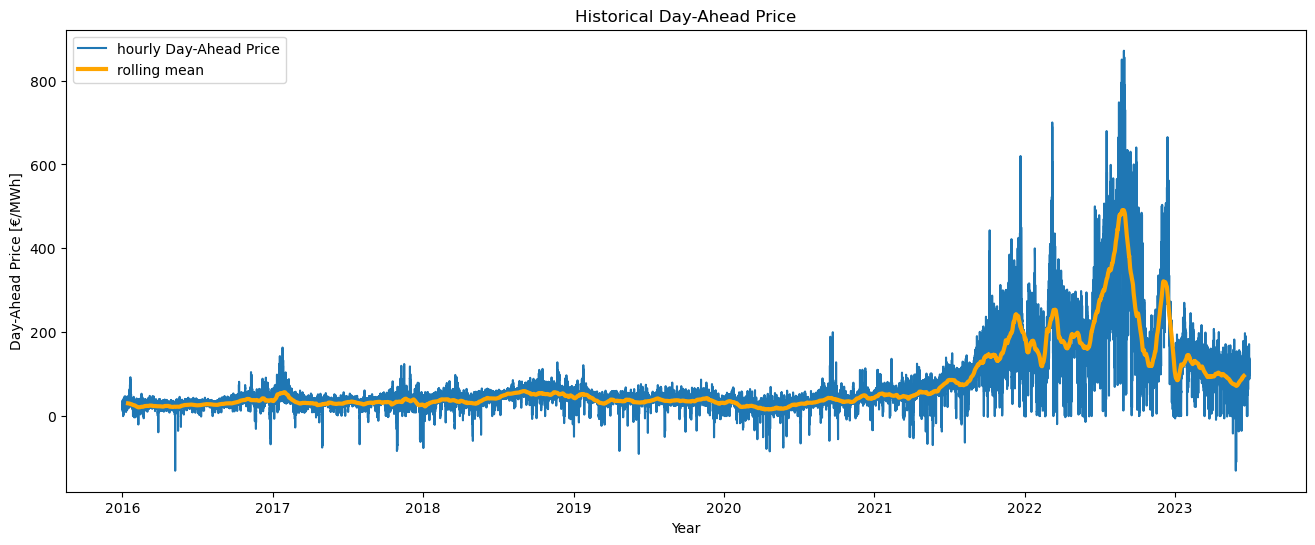

In [5]:
plt.figure(figsize=(16,6))
plt.plot(df['Day-Ahead Price [€/MWh]'], label='hourly Day-Ahead Price')
plt.plot(df['Day-Ahead Price [€/MWh]'].rolling(24*7*4, center=True).mean(), label='rolling mean', color='orange', linewidth=3)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Day-Ahead Price [€/MWh]')
plt.title('Historical Day-Ahead Price')
plt.show()

We see that from the end of 2021, the price of electricity has become significantly more expensive and volatility has increased sharply. In the years between 2016 and 2020, the average price remains more or less the same. The highest electricity price was €871, while the lowest was minus €130.09. This shows the great uncertainty in the electricity market, which in turn shows the need for a well-functioning electricity price forecasting tool.

In [7]:
df.describe().round(2)

Day-Ahead Price [€/MWh]  Forecasted Load [summed up MW]  \
count                 65711.00                        65711.00   
mean                     74.63                       229372.09   
std                      91.57                        51371.99   
min                    -130.09                            0.00   
25%                      29.91                       198049.50   
50%                      42.10                       231340.00   
75%                      75.92                       265265.50   
max                     871.00                       345633.00   

       Forecasted Renewable Generation [summed up MW]  
count                                        65711.00  
mean                                         72711.40  
std                                          45158.88  
min                                              0.00  
25%                                          35718.50  
50%                                          64704.00  
75%                                         103042.00  
max                                         260841.00

It now seems reasonable to assume that the high volatility is due to the weather-dependent nature of renewable energy, which is difficult to store. A change in electricity demand could also play a role. However, we see that the price of electricity has risen disproportionately compared to renewables. If we look at the first months of 2023, we see a significant increase in renewables by a factor of 1.71, but a significant decrease in the electricity price from 8.12 in 2022 to 3.65 in 2023. Electricity demand falls by around 10% over the years, although it has risen slightly in the last three years.

These results suggest that there is no monocausal reason for electricity price increases. Rather, socio-political factors such as the COVID-19 pandemic and the war in Ukraine also have an impact on electricity prices, e.g. through rising gas prices.

In [8]:
get_growth_rates(df)

Day-Ahead Price [€/MWh]  Forecasted Load [summed up MW]  \
2016                 1.000000                        1.000000   
2017                 1.179627                        1.032046   
2018                 1.534337                        0.895510   
2019                 1.299633                        0.895365   
2020                 1.051349                        0.886673   
2021                 3.341669                        0.913565   
2022                 8.123736                        0.908634   
2023                 3.587962                        0.893594   

      Forecasted Renewable Generation [summed up MW]  
2016                                        1.000000  
2017                                        1.237924  
2018                                        1.317174  
2019                                        1.403806  
2020                                        1.490578  
2021                                        1.364995  
2022                                        1.535224  
2023                                        1.680273

# Feature Engineering

The forecasting model is not trained on the raw data, but on features that can better reflect the characteristics of a time series. Therefore, in the following, different lag features are generated from the downloaded data.

Lag features, also known as delayed features, play a crucial role in predicting time series. These features represent past observations or values of a time series and serve as input to the AI model. By incorporating lag features into the model, it becomes possible to capture past patterns and trends to make accurate predictions for future values. 

In a 2021 paper on best practices in energy price forecasting, Lago et al. describe a dataset of lagged features that is also used in this notebook. However, only data between 9th January 2012 and 31st December 2017 were used in that paper (Lago et al., 2021). Therefore, a function was written to reconstruct these features in order to use more recent data to train the model.

In [9]:
X, y  = create_features_and_targets(df)

# Gradient Boosting Model Training
In the following, we will first train an XGBoost (Extreme Gradient Boosting) model. This model is a powerful and widely used machine learning algorithm known for its exceptional predictive performance. It belongs to the family of boosting algorithms, which are ensemble learning techniques that combine multiple weak models to create a strong predictive model.

The algorithm uses decision trees as the base learners or weak models. Decision trees are simple yet powerful models that learn hierarchical rules and make predictions by traversing a tree-like structure. XGBoost adapts decision trees to optimize the objective function efficiently, making it suitable for both regression and classification tasks.

XGBoost has been successfully applied in various domains and machine learning tasks. It has consistently delivered top-performing solutions in industry competitions, such as the Kaggle data science competitions. With its effectiveness in regression, classification, ranking, and recommendation systems, XGBoost has become a popular choice for both academic research and real-world applications.

The model is trained with data from the period between 2016 and 2019. During this period, the day-ahead price is largely constant. For a short estimation of the results, the number of estimators is set to 500.

In [10]:
X_train = X.loc[X.index.year.isin([2016, 2017, 2018, 2019])]
y_train = y.loc[y.index.year.isin([2016, 2017, 2018, 2019])]

model_2016_2019 = fit_xgb_model(X_train, y_train, hyperparameter = False)

[0]	validation_0-rmse:39.37287
[100]	validation_0-rmse:16.07987
[200]	validation_0-rmse:7.84642
[300]	validation_0-rmse:4.94692
[400]	validation_0-rmse:3.75829
[499]	validation_0-rmse:3.13038


The metrics used are mean absolute error (MAE), root mean squared error (RMSE) and semtric mean absolute percentrige error (sMAPE). The sMAPE is particularly useful for assessing the performance of the model over changing average prices. It is a widely used metric for evaluating forecast accuracy in energy price forecasting. The sMAPE provides a symmetric measure that considers both overestimations and underestimations of prices, which is crucial in this domain. Being a percentage-based metric, it enables easy comparability, while also being robust against extreme values commonly encountered in energy price data.

In [11]:
X_test = X.loc[X.index.year.isin([2020])]
y_test = y.loc[y.index.year.isin([2020])]

prediction = model_2016_2019.predict(X_test)
model_evaluation(p_real=y_test, p_pred=prediction)

MAE on test set: 7.10
RMSE on test set: 11.09
sMAPE on test set: 31.44


We find that the model can make a good prediction for the year 2020 if we use data from 2016 to 2019. However, when we test the model with data from 2023, it fails. This tells us that the choice of training years plays a crucial role in the performance of the model. This raises the question of which years should be used to train a model that is to have good predictive power for the current period.

In [12]:
X_test = X.loc[X.index.year.isin([2023])]
y_test = y.loc[y.index.year.isin([2023])]

prediction = model_2016_2019.predict(X_test)
model_evaluation(p_real=y_test, p_pred=prediction)

MAE on test set: 55.27
RMSE on test set: 62.95
sMAPE on test set: 71.22


The following function uses the sMAPE to determine the most appropriate period of years for the 2023 forecast period. To do this, an XGBoost model is trained on each subset and the number of estimators is also limited to 500. Over the course of the project, this number of estimators has proven to be a good compromise between accuracy and computational complexity. To ensure that the most recent data is always included in the dataset, the year 2022 has been included in all variants. The function thus determines how far back in time to look in order to include the most recent events.

In [13]:
best_feature_set = find_best_feature_set(X, y, X_test, y_test, n_estimators=500)
print(f'Best feature set: {best_feature_set}')

Determine best feature set...
Best feature set: [2020, 2021, 2022]


A new XGBoost model will now be trained with this set of features. If the hyperparameter option is false, only a model with the above number of estimators is trained. If the option is True, a random grid search is used to optimise the number of estimators and the maximum depth of each decision tree. To do this, the training data is split into five parts with a time series split and 20 iterations are calculated for each split. The calculated model is then stored in the best_models directory. The exact procedure of the function can be found in the models.py file.

In [14]:
X_train = X.loc[X.index.year.isin(best_feature_set)]
y_train = y.loc[y.index.year.isin(best_feature_set)]

model_best_feature_set = fit_xgb_model(X_train, y_train, hyperparameter = False)

[0]	validation_0-rmse:173.48090
[100]	validation_0-rmse:69.96980
[200]	validation_0-rmse:30.89464
[300]	validation_0-rmse:15.77587
[400]	validation_0-rmse:9.71214
[499]	validation_0-rmse:7.11187


Since hyperparametertuning has a high computational cost, the option should either be Flase or an already optimised model should be loaded with the following lines of code.

In [27]:
model_best_feature_set = xgb.XGBRegressor()
model_best_feature_set.load_model('best_models/xgb_price_model_20230626172052.txt')

In [28]:
X_test = X.loc[X.index.year.isin([2023])]
y_test = y.loc[y.index.year.isin([2023])]

prediction = model_best_feature_set.predict(X_test)
model_evaluation(p_real=y_test, p_pred=prediction)

MAE on test set: 21.21
RMSE on test set: 28.40
sMAPE on test set: 28.10


With the new best feature set, we get significantly better results. To give an overview of the best and worst weeks of the test period, the best and worst three weeks are plotted below. 

In [29]:
error = np.abs(y_test - prediction).mean(axis=1)
error.resample('W-Mon').mean().sort_values().head(5)

2023-02-27    11.722901
2023-04-17    13.150768
2023-05-08    13.439612
2023-07-03    14.038433
2023-03-06    14.427421
dtype: float64

In [30]:
# in the worst week the time was changed
# the fourthed worst week is no longer in the period under consideration
error.resample('W-Mon').mean().sort_values(ascending=False).head(5)

2023-01-02    45.652071
2023-03-27    38.168773
2023-01-16    34.808335
2023-01-09    32.698523
2023-02-20    29.518167
dtype: float64

If the price is periodically uniform, the model is able to give good results or follow this periodicity well. However, if there are large price fluctuations, they are difficult to predict. Nevertheless, the model provides valuable information for estimating the price evolution over the period of the day-ahead price, which improves energy-efficient and energy-flexible production control.

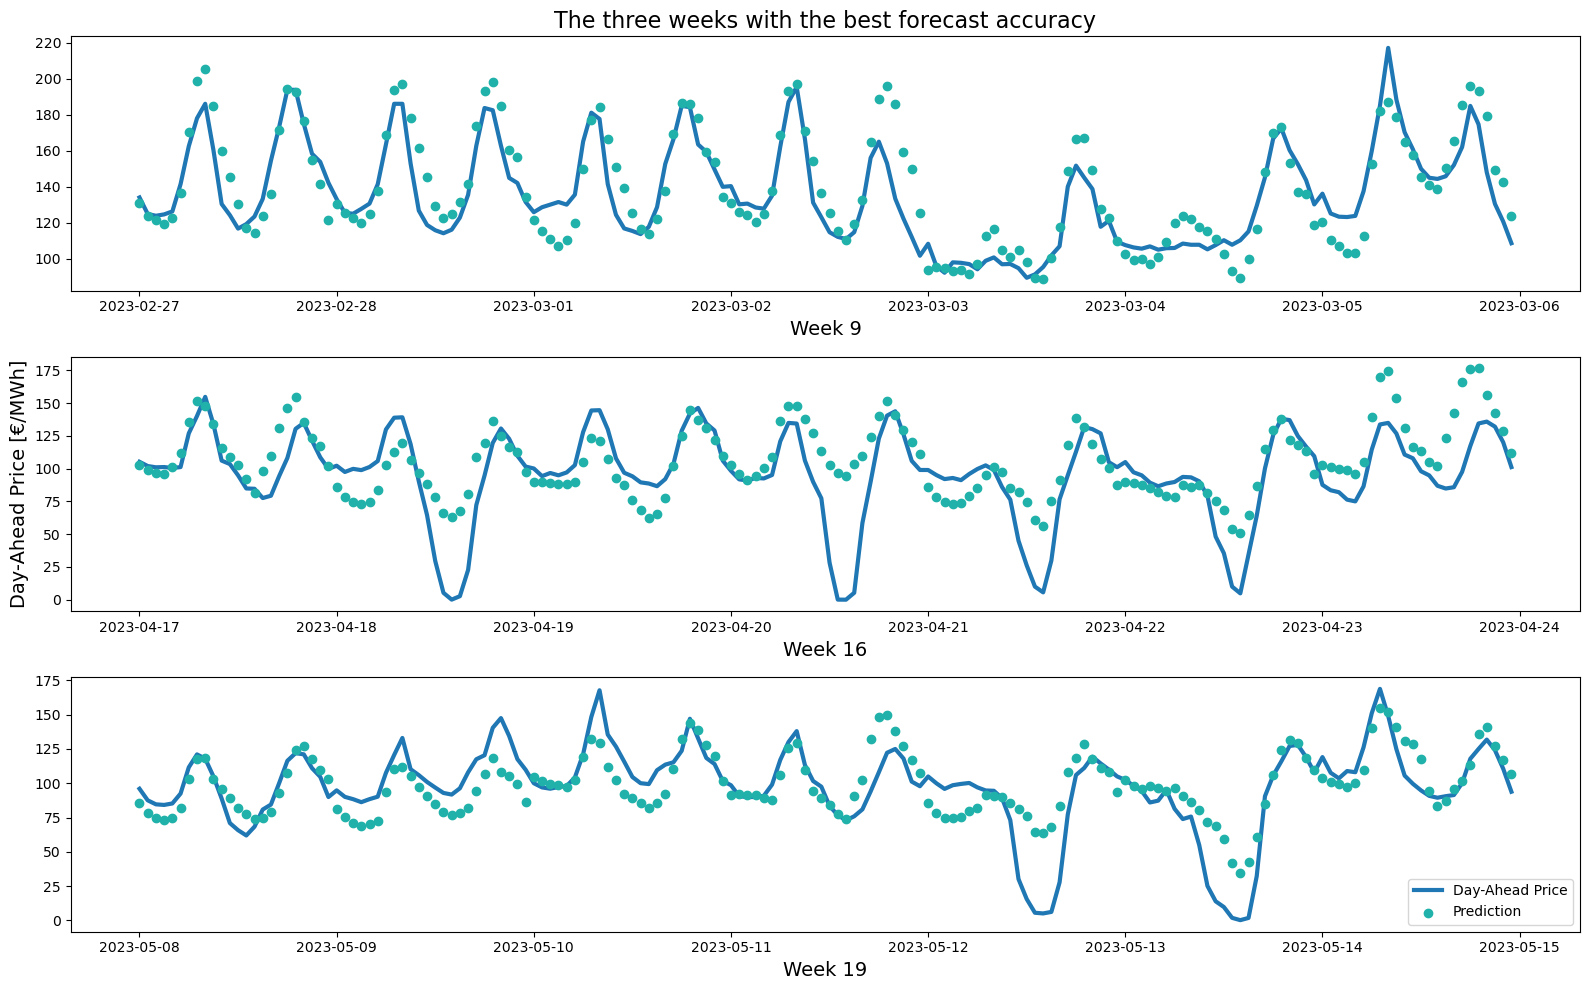

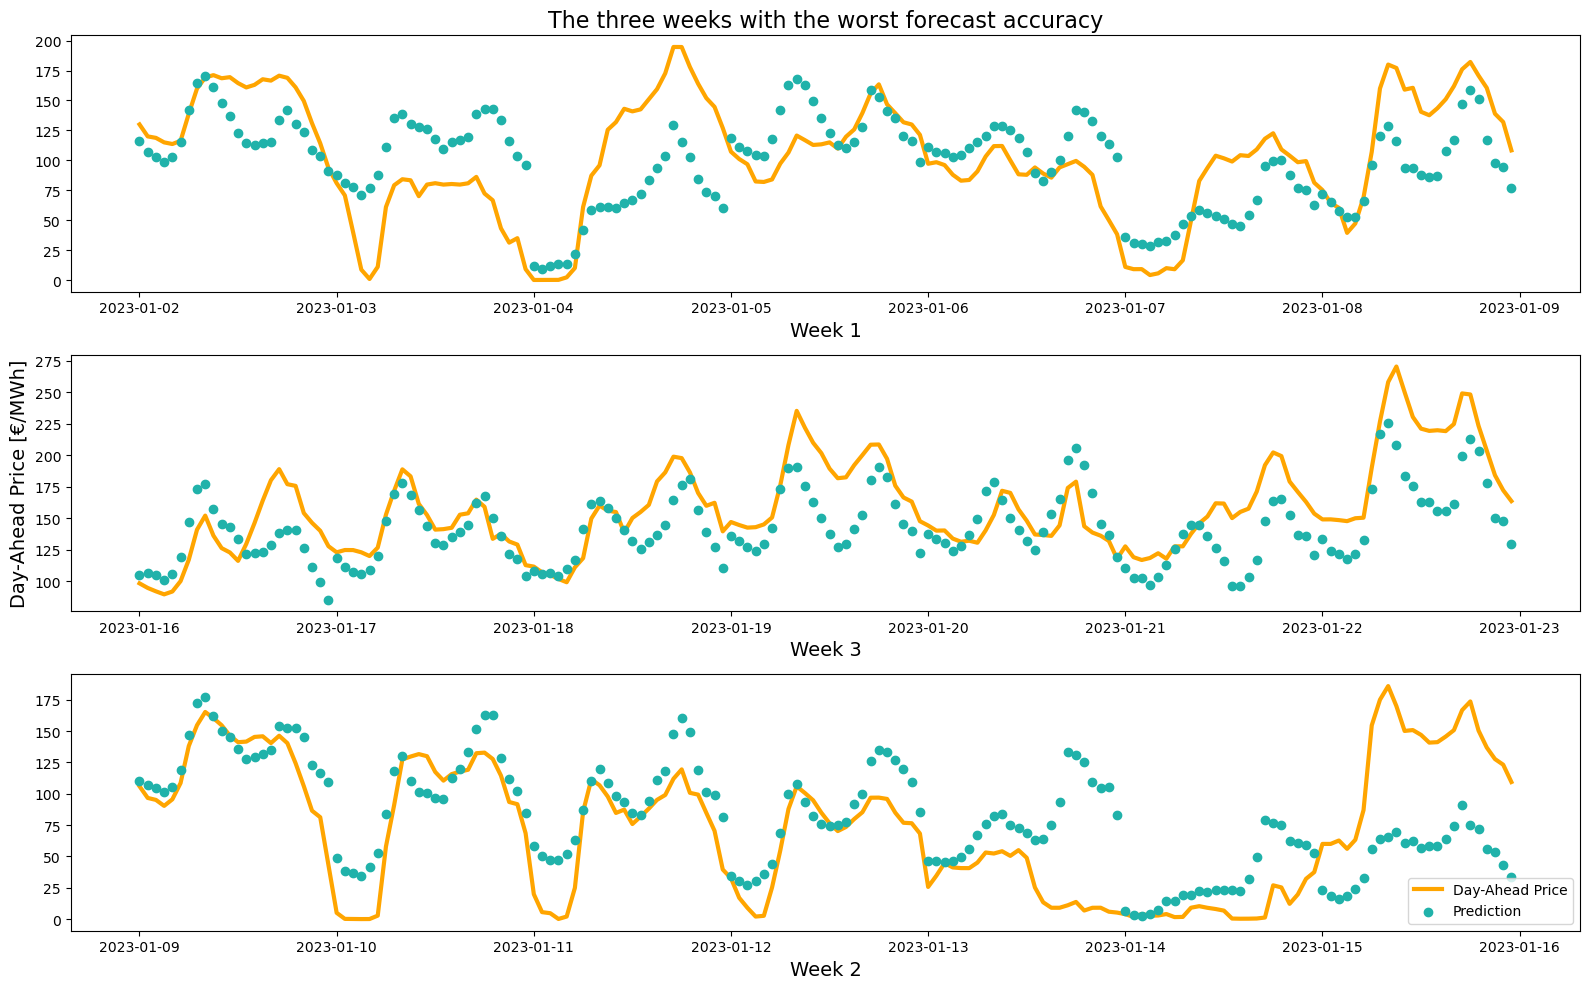

In [31]:
plot_price_forecast_weeks(y_test=y_test, prediction=prediction, best_weeks=True, worst_weeks=True)

# LSTM Model

In addition to gradient boosting models, Long Short Term Memory (LSTM) models have also been investigated and are discussed below.

LSTM models are a special type of recurrent neural network (RNN) that are well suited to time series prediction. LSTM models are characterised by their ability to capture long dependencies in a time series by using internal memory cells. These internal memory cells allow LSTM models to effectively store and access past information to make accurate predictions for the future. This capability makes LSTM models particularly well suited to predicting time series where past observations can have a strong influence on future values. 

A disadvantage of LSTM models is their high computational complexity, especially when processing large datasets, which can lead to longer training times. In addition, LSTM models can be prone to overfitting, especially if the network architecture is not properly tuned.

In [20]:
# Converte the datafraem into a numpy array
df_lstm = df.loc[df.index.year.isin([2020, 2021, 2022])].to_numpy()

# Calculate the min and max values for scaling the training data
train_min_val = np.min(df_lstm, axis=0)
train_max_val = np.max(df_lstm, axis=0)

# Days to look in the future and past
n_future = 24
n_past = 24*3

First, the data must be scaled, as the activation functions of the LSTM model can be sensitive to values that are far apart or particularly high. This step was not necessary with the previous XGBoost model. A min-max-scaling is selected as the scaling mode. Care must be taken to ensure that no information is transferred from the test data set to the training data set. Therefore, the extremes are only determined for the training data set. All data sets are scaled based on these extreme values.

In [21]:
df_scalded = min_max_scaler(df_lstm, min_val=train_min_val, max_val=train_max_val)

Unlike the lag features in the XGBoost model, the LSTM model defines rolling windows. These data windows capture 3 days of raw data from the past, which is the input to the model. The output of the LSTM model is the next 24 hours, just like the previous model. The rolling window is shifted by one hour each time. The idea is that the LSTM model, through its internal long-term memory, is able to recognise and learn patterns from the past data itself. 

In [22]:
X_train, y_train = WindowGenerator(df_scalded, n_future, n_past)

X shape == (26209, 72, 3).
Y shape == (26209, 24).


The next step is to train the LSTM model. Due to the many parameters within an LSTM neuron, training is much more complex than for gradient boosting models. 

In [23]:
lstm_model = fit_lstm_model(X_train, y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
Total params: 6,456
Trainable params: 6,456
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
656/656 [==============================] - 7s 9ms/step - loss: 0.0340 - val_loss: 0.0804
Epoch 2/100
656/656 [==============================] - 6s 9ms/step - loss: 0.0251 - val_loss: 0.0779
Epoch 3/100
656/656 [==============================] - 6s 9ms/step - loss: 0.0247 - val_loss: 0.0758
Epoch 4/100
656

To obtain a prediction, the test data set is also scaled and formatted as a rolling window. The prediction or output of the LSTM model is also scaled and needs to be backscaled for better interpretation and presentation of the results. The minimum and maximum values of the training data set are also used for this backscaling.

In [24]:
df_test = df.loc[df.index.year.isin([2023])].to_numpy()
df_test_scalded = min_max_scaler(df_test, min_val=train_min_val, max_val=train_max_val)
X_test, y_test = WindowGenerator(df_test_scalded, n_future, n_past)

prediction = lstm_model.predict(X_test)

prediction_inverse = inverse_min_max_scaler(prediction, min_val=train_min_val, max_val=train_max_val)
y_test_inverse = inverse_min_max_scaler(y_test, min_val=train_min_val, max_val=train_max_val)

X shape == (4248, 72, 3).
Y shape == (4248, 24).
133/133 [==============================] - 1s 3ms/step


In [25]:
prediction_inverse = inverse_min_max_scaler(prediction, min_val=train_min_val, max_val=train_max_val)
y_test_inverse = inverse_min_max_scaler(y_test, min_val=train_min_val, max_val=train_max_val)

The LSTM model does not match the accuracy of the XGBoost model. This is not necessarily due to the general ability of this AI model to predict time series. LSTM models have been shown many times in the past to be excellent forecasters. A disadvantage of this model, however, as mentioned above, is its high computational cost, which is why no hyperparameter tuning was performed as part of the ADP.

In [26]:
model_evaluation(p_real=y_test_inverse, p_pred=prediction_inverse)

MAE on test set: 25.13
RMSE on test set: 34.00
sMAPE on test set: 30.68


# Bibliography

Lago, J., Marcjasz, G., De Schutter, B., & Weron, R. (2021). Forecasting day-ahead electricity prices: A review of state-of-the-art algorithms, best practices and an open-access benchmark. Applied Energy, 293, 116983. https://doi.org/10.1016/j.apenergy.2021.116983